In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bt5153-applied-machine-learning-spring-2023/sample_submission.csv
/kaggle/input/bt5153-applied-machine-learning-spring-2023/train.csv
/kaggle/input/bt5153-applied-machine-learning-spring-2023/test.csv


In [2]:
# Install Packages
!pip install bert-for-tf2
!pip install tensorflow_hub
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=4644a34a2ee373fd35bdba499719e751376a0860ad5c876540f62322221e5c06
  Stored in directory: /root/.cache/pip/wheels/d3/b3/5f/1ba04fd4e099213b9c9a3f5b1ac5548fa2e599cb8fc9a868cc
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=c274f4d35f3385e0f5b8d7b9a467a3441b15f252f0a0b9649a2af83235d0ea43
  Stored in directory: /root/.cache/pip/wheels/91/17/7a/d8dc86bae260c349990d0c36b60685b2c4cd601866d083d471
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=adee57cc664b98bef6ab5c5c90353103ccce1be09b8fadb2c6f05550f2369a65
  Stored in directory: /root/.cache/pip/wheels/c4/94/74/551bca501c76c25b5f8512e8dc531f9a24dd221cdbbd3e63

In [3]:
# Load Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import joblib

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
pd.set_option('display.max_colwidth',1000)

TensorFlow Version: 2.11.0
Hub version:  0.12.0


In [4]:
# Import train and test dataset

train_data = pd.read_csv("/kaggle/input/bt5153-applied-machine-learning-spring-2023/train.csv")
test_data = pd.read_csv("/kaggle/input/bt5153-applied-machine-learning-spring-2023/test.csv")

In [5]:
# Create train dataset copy
train_df = train_data

In [7]:
# Print Train data info

print("First five rows in train datset:\n\n", train_data.head())
print("\n")
print("Total rows and columns in train dataset:\n\n", train_data.shape)
print("\n")
print(train_data.info())
print("\n")
print("Summary of train dataset:\n\n", train_data.describe())
print("\n")
print("Null values in train dataset:\n\n", train_data.isnull().sum())
print("\n")

First five rows in train datset:

    Id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [8]:
# Print Test data info

print(test_data.head())
print("\n")
print(test_data.shape)
print("\n")
print(test_data.info())
print("\n")

   Id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

0    12499
1    12496
Name: Sentiment, dtype: int64




Text(0.5, 1.0, 'Sentiment Target Distribution')

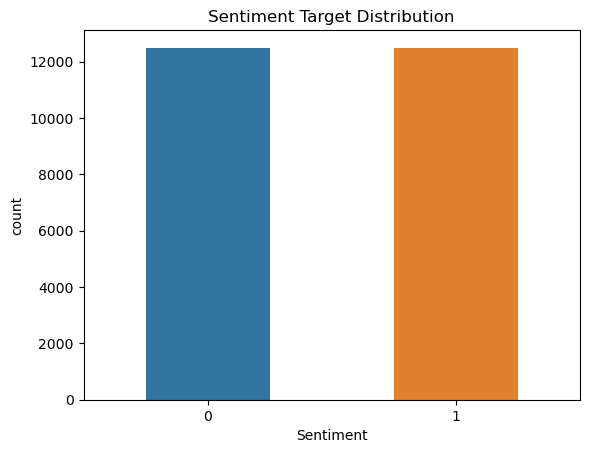

In [17]:
# Check the target class balance
print(train_data['Sentiment'].value_counts()) #It's a balanced dataset
print("\n")
sns.countplot(x=train_data.Sentiment,width = .5)
plt.title("Sentiment Target Distribution")

In [10]:
# Check Unique 'Text' values in both train and test dataset
print("Count of Unique Texts in Train Data:",train_data['Text'].nunique())
print(train_data.shape)

print("Count of Unique Texts in Test Data:",test_data['Text'].nunique())
print(test_data.shape)

## Both train and test dataset have duplicate texts

Count of Unique Texts in Train Data: 24899
(24995, 3)
Count of Unique Texts in Test Data: 25666
(25865, 2)


In [11]:
# Check the first text in train data
train_data['Text'][0]

'American movies about war and Nazis simply cannot be good. They can not refrain from becoming idiot and following an agenda. All Nazis are bad, crazy, too proud, and Americans are so modest yet so capable and sensible and human. Come on, stop this bullshit. The main character says something like "by this trial, we have to make aggressive war a crime". Is America a peaceful nation with its world #1 $420 billion "defense" budget (#2 China with just $51b)? Is it simply spent in this without any... ROI? Why portray America as a peaceful nation when it isn\'t? I deeply dislike movies with an agenda - they throw art to hell and try to persuade us into believing something. Hollywood should put a label on movies, just as record companies have that "parental advisory" label. We should have a "bullshit advisory", "propaganda advisory" or a "politically correct advisory" label on some movies. This is one of them.'

In [6]:
# Set "Id" column as index in train data
train_data = train_data.set_index('Id')
train_data.head(2)

,Text,Sentiment
Id,,
0,"American movies about war and Nazis simply cannot be good. They can not refrain from becoming idiot and following an agenda. All Nazis are bad, crazy, too proud, and Americans are so modest yet so capable and sensible and human. Come on, stop this bullshit. The main character says something like ""by this trial, we have to make aggressive war a crime"". Is America a peaceful nation with its world #1 $420 billion ""defense"" budget (#2 China with just $51b)? Is it simply spent in this without any... ROI? Why portray America as a peaceful nation when it isn't? I deeply dislike movies with an agenda - they throw art to hell and try to persuade us into believing something. Hollywood should put a label on movies, just as record companies have that ""parental advisory"" label. We should have a ""bullshit advisory"", ""propaganda advisory"" or a ""politically correct advisory"" label on some movies. This is one of them.",0
1,"Who would have thought that a movie about a man who drives a couple hundreds of miles on his lawn mower to see his brother, could possibly be good cinema? I certainly didn't. I thought I knew what to expect: one of the most boring experiences of my life. Well I was as wrong as I haven't been wrong too often yet, because this is one of the best, most realistic and honest Hollywood films I've ever seen...<br /><br />Giving a short resume of ""The Straight Story"" isn't very difficult. It's about an old and stubborn man who steps on his lawn mower and drives off to another state to pay his brother a visit when he hears that the man has had a severe stroke. That's already special on itself, but what makes it even more special is the fact that he hasn't seen his brother in ten years because of some stupid argument. In the meantime he has his share of bad luck and problems, but he also meets a lot of people whose lives he influences in one way or another with his philosophical approach to ...",1


In [13]:
# Perform drop duplicate on train data to get unique data
# train_data = train_data.drop_duplicates()
# print("Updated Train Data:", train_data.shape)
# print("Original Train Data:", train_df.shape)

In [7]:
# Create new "sentiment" column. 0 = Negative and 1 = positive
def label_change(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Positive"
    
train_data['sentiment'] = train_data['Sentiment'].apply(lambda x: label_change(x))
print(train_data.head())
print("\n")

print(train_data['Sentiment'].value_counts())
print(train_data['sentiment'].value_counts())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       T

In [8]:
# Create copy of original train dataset

training_data = train_data
training_data.head(2)

,Text,Sentiment,sentiment
Id,,,
0,"American movies about war and Nazis simply cannot be good. They can not refrain from becoming idiot and following an agenda. All Nazis are bad, crazy, too proud, and Americans are so modest yet so capable and sensible and human. Come on, stop this bullshit. The main character says something like ""by this trial, we have to make aggressive war a crime"". Is America a peaceful nation with its world #1 $420 billion ""defense"" budget (#2 China with just $51b)? Is it simply spent in this without any... ROI? Why portray America as a peaceful nation when it isn't? I deeply dislike movies with an agenda - they throw art to hell and try to persuade us into believing something. Hollywood should put a label on movies, just as record companies have that ""parental advisory"" label. We should have a ""bullshit advisory"", ""propaganda advisory"" or a ""politically correct advisory"" label on some movies. This is one of them.",0,Negative
1,"Who would have thought that a movie about a man who drives a couple hundreds of miles on his lawn mower to see his brother, could possibly be good cinema? I certainly didn't. I thought I knew what to expect: one of the most boring experiences of my life. Well I was as wrong as I haven't been wrong too often yet, because this is one of the best, most realistic and honest Hollywood films I've ever seen...<br /><br />Giving a short resume of ""The Straight Story"" isn't very difficult. It's about an old and stubborn man who steps on his lawn mower and drives off to another state to pay his brother a visit when he hears that the man has had a severe stroke. That's already special on itself, but what makes it even more special is the fact that he hasn't seen his brother in ten years because of some stupid argument. In the meantime he has his share of bad luck and problems, but he also meets a lot of people whose lives he influences in one way or another with his philosophical approach to ...",1,Positive


In [ ]:
### Initial Data Pre-processing and visualization

##Note: couldn't run texthero package on kaggle notebook or jupyter so ran separately on google colab for visualization and preprocessing for baseline model.

# Install Packages

#!pip install texthero
#!pip install -U spacy

#import texthero as hero

#create custom pipeline for cleaning "Text" feature (Data pre-processing)
#custom_pipeline = [hero.preprocessing.fillna,
#                   hero.preprocessing.lowercase,
#                   hero.preprocessing.remove_whitespace,
#                   hero.preprocessing.remove_urls,
#                   hero.preprocessing.remove_diacritics,
#                   hero.preprocessing.remove_digits,
#                   hero.preprocessing.remove_punctuation,
#                   hero.preprocessing.remove_stopwords,
#                   hero.preprocessing.remove_round_brackets,
#                   hero.preprocessing.remove_html_tags,
#                   hero.preprocessing.remove_curly_brackets,
#                   hero.preprocessing.remove_brackets,
#                   ]


#train_data['Clean_Text'] = train_data['Text'].pipe(hero.clean, custom_pipeline)

#print(train_data[['Text', 'Clean_Text']].head())

## Data Visualization using texthero package

#NUM_TOP_WORDS = 20
#top_20 = hero.visualization.top_words(train_data.loc[:, 'Clean_Text']).head(NUM_TOP_WORDS)
#top_20.plot.bar(rot=90, title="Top 20 words in text");
#plt.show(block=True);

#Plot wordcloud image using WordCloud method

#hero.wordcloud(train_data.loc[:, 'Clean_Text'], max_words=100)

#scatterplot

#hero.scatterplot(train_data, 'Clean_Text')

# Pre-Trained Bert Model

In [16]:
# Split the train dataset into train and val sets
train_text, val_text, train_labels, val_labels = train_test_split(training_data['Text'].tolist(), training_data['Sentiment'].tolist(), test_size=0.2)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
# Set the device to run on (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    bert_model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1} Training Loss: {train_loss/len(train_dataloader)}")

Epoch 1 Training Loss: 0.05551917783115059
Epoch 2 Training Loss: 0.03295207256646827
Epoch 3 Training Loss: 0.02582244212254882
Epoch 4 Training Loss: 0.023353471219725908
Epoch 5 Training Loss: 0.01677091434597969


In [24]:
# Assume "model" is a trained Scikit-learn model
joblib.dump(bert_model, 'bert_model.pkl')

['bert_model.pkl']

In [30]:
# Evaluate the model on the val set
bert_model.eval()
with torch.no_grad():
    val_loss = 0.0
    val_correct = 0
    predictions = []
    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        probs = torch.nn.functional.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        predictions.extend(preds.cpu().numpy())

In [33]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(val_labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2541
           1       0.86      0.90      0.88      2458

    accuracy                           0.88      4999
   macro avg       0.88      0.88      0.88      4999
weighted avg       0.88      0.88      0.88      4999



In [34]:
# Model prediction on test dataset

test_data["Sentiment"] = 0

# Tokenize the text and add special tokens
test_tokens = tokenizer.batch_encode_plus(
    test_data["Text"].tolist(),
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Pad the input sequences to have equal lengths
test_input_ids = pad_sequences(test_tokens['input_ids'], maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = pad_sequences(test_tokens['attention_mask'], maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

# Create PyTorch dataset
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_input_ids),
    torch.tensor(test_attention_masks)
)

# Create PyTorch dataloader
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

# Set the model to evaluation mode
bert_model.eval()

# Lists to store predictions
predictions = []

# Deactivate gradient computations
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        # Forward pass
        outputs = bert_model(input_ids, attention_mask=attention_mask)

        # Get the predicted class
        _, preds = torch.max(outputs[0], dim=1)

        # Append predictions to the list
        predictions.extend(preds.tolist())

# Add the predicted labels to the test dataset
test_data["Sentiment"] = np.array(predictions)
test_data.head()

,Id,Text,Sentiment
0,0,"This is probably the best movie from director Hector Babenco. It shows a Brazilian reality unknown by foreigners, which is the same reality that haunts all of the Latin American countries, poverty and a survival instinct. The most affected in this reality is the children usually left orphans, or abandoned by their poor parents have to make it in a ""dog eat dog"" society many times falling into the gap of delinquency, prostitution and crime. Very well acted and with a ""no frills"" approach, this movie will get to you, Great story plot, a must have movie on anybody's collection. The starring role went to Fernando Ramos da Silva, a young boy who fell into the crime wave, killed some years later during a robbery. I would suggest people to watch the movie ""Who killed Pixote?"" so you can have a more in depth idea of the lives of these characters. Some other Characters from the movie had a similar fate, some died and others are in jail. None the less this movie will last for a long time in ...",1
1,1,"It's particularly hard for a director to capture film-making without getting precious, inbred, over-dramatic, or all three. Breillat ably demonstrates the instinctive, lizard-brain methods of a female auteur in extracting from two ""cattle"" (as Hitchcock called actors) a love-scene of searing intimacy. Her main battle is with her leading man (""an actor is really a woman"" she opines), although, naturally, it is the leading lady who will steal the show. I disagree that this is Breillat's first comedy. 'Romance' was at various points hilarious, but I accept that the French sense of humour can be elusive for foreigners; indeed, dozens of IMDb reviewers detected no comedy in Romance. By contrast, Sex Is Comedy raises plenty of laughs, mainly by using an actor's prop that goes back thousands of years to Plautus and the ancient Greeks. We wondered, leaving the theatre, whether Roxane's ""beard"" was a wig. A lovely performance from Anne Parillaud as Breillat wrestling with her own script, lo...",1
2,2,"A very good movie about anti-semitism near the end of WWII. The scene that really speaks loudly of the ignorance of these people is the meeting at the church when the priest is giving his speech against the ""international money grubbers and communists"". It sounds amazingly like the speeches that Adolph Hitler used to force down his peoples' throats, yet none of the meeting attendees seem to make this comparison.",1
3,3,"Interesting story and sympathetic treatment of racial discrimination, Son of the Gods is rather too long and contains some hammy acting, but on the whole remains a fascinating film.<br /><br />Story about a Chinese passing as White (Rchard Barthelmess) starts as Barthelmess leaves college after being insulted by a trio of brainless co-eds. He embarks on a world tour to discover himself and ends up as secretary to a British playwright (Claude King). In Monte Carlo he meets beautiful Alanna Wagner (Constance Bennett) and they fall in love. But when she discovers he is Chinese she goes berserk in a memorable scene.<br /><br />Plagued by guilt and love, Alanna goes into a mental spiral and makes a few attempts to contact Barthelmess. After his father dies he takes over the business (banking?) and dons Chinese garb as a symbol of his hatred of the White race that has spurned him. After a San Francisco detective tells him the truth about his birth, Barthelmess makes the decision to honor...",1
4,4,"There are films that are not released in theaters but on video. This one should be allowed to age and disintegrate the way old nitrate film stock does. No story, inept violence, over acted, badly written and the sorry thing is that the star was not the only bad part in the film. And I did like and enjoyed some of Siegel's other movies.",0


In [ ]:
# Save the results to a new CSV file
bert_result = test_data[['Id', 'Sentiment']]
bert_result.to_csv('Submission_BertModel.csv', index=False)

# **TensorFlow Bert Model**

In [9]:
# Functions for constructing BERT Embeddings: input_ids, input_masks, input_segments and Inputs
MAX_SEQ_LEN=500 # max sequence length

def get_masks(tokens):
    """Masks: 1 for real tokens and 0 for paddings"""
    return [1]*len(tokens) + [0] * (MAX_SEQ_LEN - len(tokens))
 
def get_segments(tokens):
    """Segments: 0 for the first sequence, 1 for the second"""  
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (MAX_SEQ_LEN - len(tokens))

def get_ids(tokens, tokenizer):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (MAX_SEQ_LEN - len(token_ids))
    return input_ids

def create_single_input(sentence, tokenizer, max_len):
    """Create an input from a sentence"""
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:max_len]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer)
    masks = get_masks(stokens)
    segments = get_segments(stokens)

    return ids, masks, segments
 
def convert_sentences_to_features(sentences, tokenizer):
    """Convert sentences to features: input_ids, input_masks and input_segments"""
    input_ids, input_masks, input_segments = [], [], []
 
    for sentence in tqdm(sentences,position=0, leave=True):
      ids,masks,segments=create_single_input(sentence,tokenizer,MAX_SEQ_LEN-2)
      assert len(ids) == MAX_SEQ_LEN
      assert len(masks) == MAX_SEQ_LEN
      assert len(segments) == MAX_SEQ_LEN
      input_ids.append(ids)
      input_masks.append(masks)
      input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

def create_tonkenizer(bert_layer):
    """Instantiate Tokenizer with vocab"""
    vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case=bert_layer.resolved_object.do_lower_case.numpy() 
    tokenizer=bert.bert_tokenization.FullTokenizer(vocab_file,do_lower_case)
    return tokenizer

In [10]:
def nlp_model(callable_object):
    # Load the pre-trained BERT base model
    bert_layer = hub.KerasLayer(handle=callable_object, trainable=True)  
   
    # BERT layer three inputs: ids, masks and segments
    input_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_ids")           
    input_masks = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_masks")       
    input_segments = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")
    
    inputs = [input_ids, input_masks, input_segments] # BERT inputs
    pooled_output, sequence_output = bert_layer(inputs) # BERT outputs
    
    # Add a hidden layer
    x = Dense(units=768, activation='relu')(pooled_output)
    x = Dropout(0.1)(x)
 
    # Add output layer
    outputs = Dense(2, activation="softmax")(x)

    # Construct a new model
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = nlp_model("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 500)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 500)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 500, 768)]                'input_masks[0][0]',        

In [11]:
# Create examples for training and testing
train_df = training_data.sample(frac=1) # Shuffle the dataset
tokenizer = create_tonkenizer(model.layers[3])

X_train = convert_sentences_to_features(train_df['Text'][:20000], tokenizer)
X_val = convert_sentences_to_features(train_df['Text'][20000:], tokenizer)

one_hot_encoded = to_categorical(train_df['Sentiment'].values)
y_train = one_hot_encoded[:20000]
y_val =  one_hot_encoded[20000:]

100%|██████████| 4995/4995 [00:24<00:00, 205.24it/s]


In [12]:
# Train the model
BATCH_SIZE = 8
EPOCHS = 1

# Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=2e-5)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fit the data to the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose = 1)

# Save the trained model
model.save('nlp_model.h5')

2500/2500 [==============================] - 2520s 989ms/step - loss: 0.2510 - accuracy: 0.8960 - val_loss: 0.1818 - val_accuracy: 0.9305


In [13]:
# Load the pretrained nlp_model
from tensorflow.keras.models import load_model
new_model = load_model('nlp_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [21]:
# Prediction on val dataset and evaluation
pred_val = np.argmax(new_model.predict(X_val), axis=1)

157/157 [==============================] - 204s 1s/step


In [15]:
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix
print(classification_report(np.argmax(y_val,axis=1), pred_val))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2521
           1       0.96      0.90      0.93      2474

    accuracy                           0.93      4995
   macro avg       0.93      0.93      0.93      4995
weighted avg       0.93      0.93      0.93      4995



In [16]:
# Predict on test dataset

test_data["Sentiment"] = 0
X_test = convert_sentences_to_features(test_data['Text'], tokenizer)
test_pred = np.argmax(new_model.predict(X_test), axis=1)

test_data["Sentiment"] = test_pred
test_data.head()

100%|██████████| 25865/25865 [01:59<00:00, 216.12it/s]


809/809 [==============================] - 1052s 1s/step


,Id,Text,Sentiment
0,0,"This is probably the best movie from director Hector Babenco. It shows a Brazilian reality unknown by foreigners, which is the same reality that haunts all of the Latin American countries, poverty and a survival instinct. The most affected in this reality is the children usually left orphans, or abandoned by their poor parents have to make it in a ""dog eat dog"" society many times falling into the gap of delinquency, prostitution and crime. Very well acted and with a ""no frills"" approach, this movie will get to you, Great story plot, a must have movie on anybody's collection. The starring role went to Fernando Ramos da Silva, a young boy who fell into the crime wave, killed some years later during a robbery. I would suggest people to watch the movie ""Who killed Pixote?"" so you can have a more in depth idea of the lives of these characters. Some other Characters from the movie had a similar fate, some died and others are in jail. None the less this movie will last for a long time in ...",1
1,1,"It's particularly hard for a director to capture film-making without getting precious, inbred, over-dramatic, or all three. Breillat ably demonstrates the instinctive, lizard-brain methods of a female auteur in extracting from two ""cattle"" (as Hitchcock called actors) a love-scene of searing intimacy. Her main battle is with her leading man (""an actor is really a woman"" she opines), although, naturally, it is the leading lady who will steal the show. I disagree that this is Breillat's first comedy. 'Romance' was at various points hilarious, but I accept that the French sense of humour can be elusive for foreigners; indeed, dozens of IMDb reviewers detected no comedy in Romance. By contrast, Sex Is Comedy raises plenty of laughs, mainly by using an actor's prop that goes back thousands of years to Plautus and the ancient Greeks. We wondered, leaving the theatre, whether Roxane's ""beard"" was a wig. A lovely performance from Anne Parillaud as Breillat wrestling with her own script, lo...",1
2,2,"A very good movie about anti-semitism near the end of WWII. The scene that really speaks loudly of the ignorance of these people is the meeting at the church when the priest is giving his speech against the ""international money grubbers and communists"". It sounds amazingly like the speeches that Adolph Hitler used to force down his peoples' throats, yet none of the meeting attendees seem to make this comparison.",1
3,3,"Interesting story and sympathetic treatment of racial discrimination, Son of the Gods is rather too long and contains some hammy acting, but on the whole remains a fascinating film.<br /><br />Story about a Chinese passing as White (Rchard Barthelmess) starts as Barthelmess leaves college after being insulted by a trio of brainless co-eds. He embarks on a world tour to discover himself and ends up as secretary to a British playwright (Claude King). In Monte Carlo he meets beautiful Alanna Wagner (Constance Bennett) and they fall in love. But when she discovers he is Chinese she goes berserk in a memorable scene.<br /><br />Plagued by guilt and love, Alanna goes into a mental spiral and makes a few attempts to contact Barthelmess. After his father dies he takes over the business (banking?) and dons Chinese garb as a symbol of his hatred of the White race that has spurned him. After a San Francisco detective tells him the truth about his birth, Barthelmess makes the decision to honor...",1
4,4,"There are films that are not released in theaters but on video. This one should be allowed to age and disintegrate the way old nitrate film stock does. No story, inept violence, over acted, badly written and the sorry thing is that the star was not the only bad part in the film. And I did like and enjoyed some of Siegel's other movies.",0


In [ ]:
bertTensor_result = test_data[['Id', 'Sentiment']]
bertTensor_result.to_csv('Submission_TensorFlow2_BertModel.csv', index=False)